# NIFTY Index prediction using ARIMA Model

### Import Libraries

In [30]:
import os
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import datetime as dt
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Import Datasets

In [31]:
nifty = pd.read_csv("Dataset/nifty.csv")

In [32]:
nifty.head()

,Date,Open,High,Low,Close
0,01-01-1996,913.11,913.11,906.15,908.01
1,02-01-1996,906.78,906.78,899.52,900.38
2,03-01-1996,901.66,904.48,895.48,895.96
3,04-01-1996,891.37,891.37,884.10,889.67
4,05-01-1996,887.79,887.79,881.74,884.73


### Visualize NIFTY Data

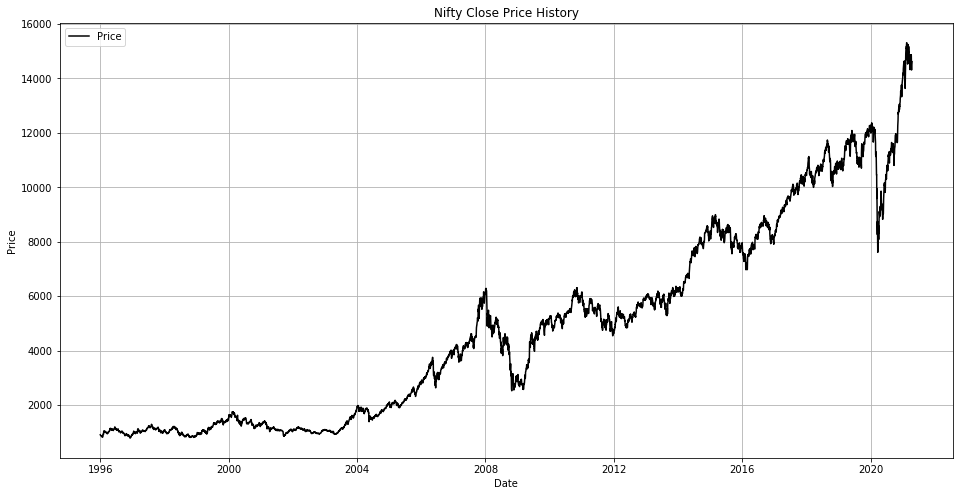

In [33]:
new_date = [dt.datetime.strptime(d,'%d-%m-%Y').date() for d in nifty['Date']]
plt.figure(figsize=(16,8))
plt.title('Nifty Close Price History')
plt.plot(new_date, nifty['Close'],label='Price', color='black')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.legend(loc=2)

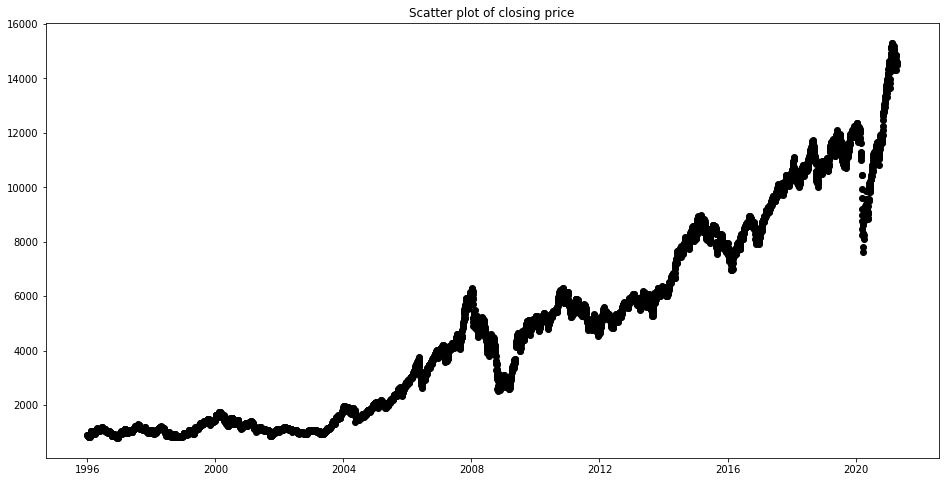

In [34]:
plt.figure(figsize=(16,8))
plt.scatter(new_date,nifty['Close'], color='black')
plt.title('Scatter plot of closing price')
plt.show()

### Augmented Dickey Fuller Test

Testing For Stationarity on the main dataset:

To identify the nature of the data, we will be using the null hypothesis.

H0: The null hypothesis: It is a statement about the population that either is believed to be true or is used to put forth an argument unless it can be shown to be incorrect beyond a reasonable doubt. <b>It is non-stationary</b>

H1: The alternative hypothesis: It is a claim about the population that is contradictory to H0 and what we conclude when we reject H0. <b>It is stationary</b>

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear.

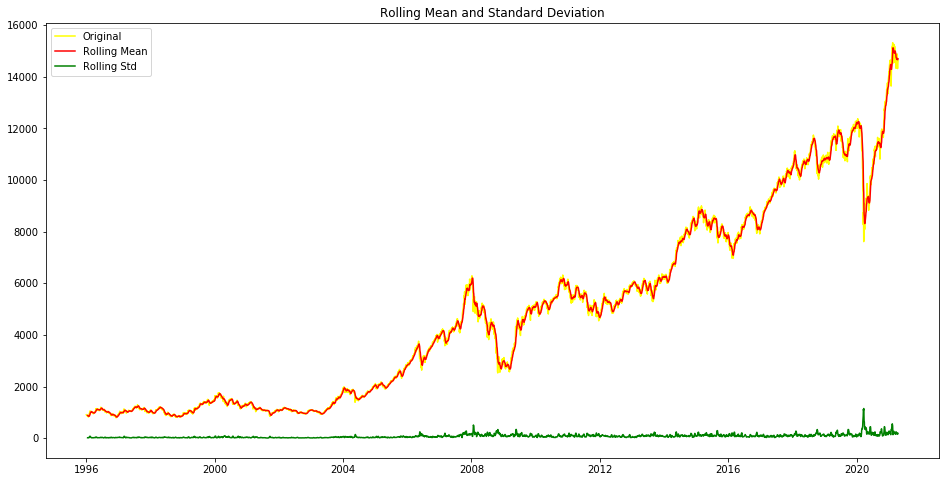

Results of dickey fuller test
Test Statistics                   0.825275
p-value                           0.992033
No. of lags used                 18.000000
Number of observations used    6276.000000
critical value (1%)              -3.431392
critical value (5%)              -2.862001
critical value (10%)             -2.567015
dtype: float64


In [35]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.figure(figsize=(16,8))
    plt.plot(new_date, timeseries, color='yellow',label='Original')
    plt.plot(new_date, rolmean, color='red', label='Rolling Mean')
    plt.plot(new_date, rolstd, color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(nifty['Close'])

As the p-value is greater than 0.05 so we cannot reject the <b>Null hypothesis</b>. Also, the test statistics is greater than the critical values, so the data is non-stationary.

### Logarithmic Moving Average and Standard Deviation

No handles with labels found to put in legend.


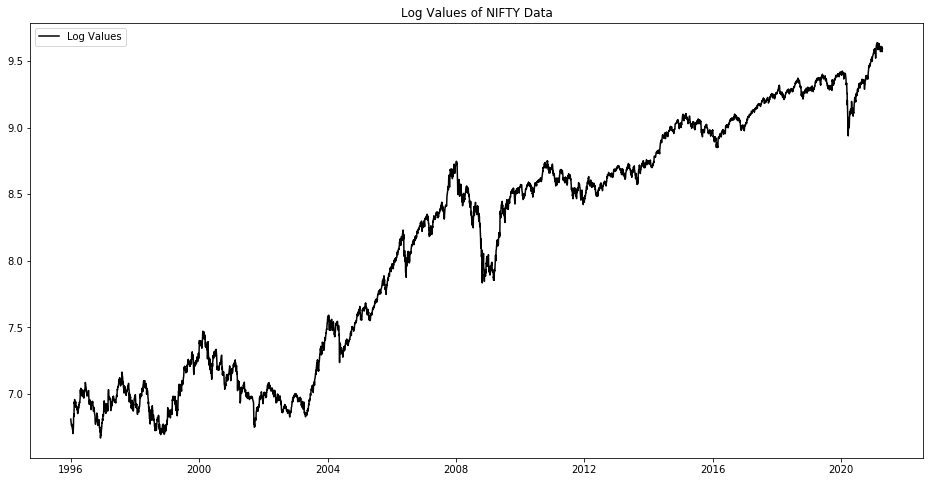

In [36]:
nifty['log_close'] = np.log(nifty['Close'])
plt.figure(figsize=(16,8))
plt.legend(loc='best')
plt.title('Log Values of NIFTY Data')
plt.plot(new_date, nifty['log_close'], color ="black", label = "Log Values")
plt.legend()
plt.show()

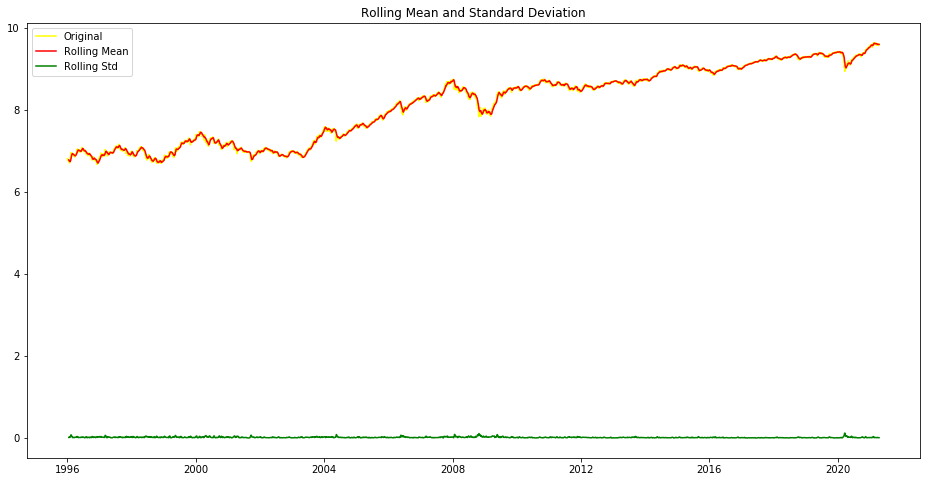

Results of dickey fuller test
Test Statistics                  -0.617038
p-value                           0.867085
No. of lags used                 20.000000
Number of observations used    6274.000000
critical value (1%)              -3.431393
critical value (5%)              -2.862001
critical value (10%)             -2.567015
dtype: float64


In [37]:
def test_stationarity_onlog(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.figure(figsize=(16,8))
    plt.plot(new_date, timeseries, color='yellow',label='Original')
    plt.plot(new_date, rolmean, color='red', label='Rolling Mean')
    plt.plot(new_date, rolstd, color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity_onlog(nifty['log_close'])

Still, we can see that, the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values, so the data is non-stationary.

### Differencing

No handles with labels found to put in legend.


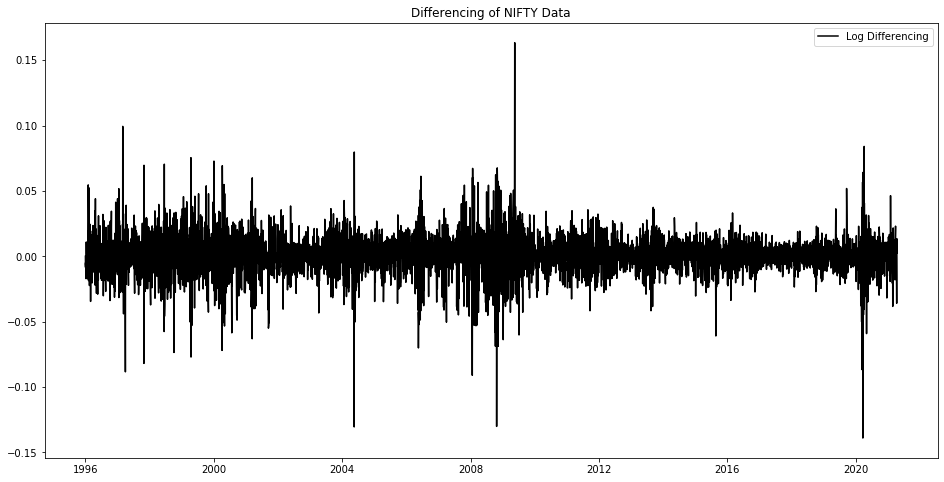

In [38]:
nifty['diff_close'] = nifty['log_close'] - nifty['log_close'].shift(1)
nifty['diff_close'] = nifty['diff_close'].fillna(0)
plt.figure(figsize=(16,8))
plt.legend(loc='best')
plt.title('Differencing of NIFTY Data')
plt.plot(new_date, nifty['diff_close'], color ="black", label = "Log Differencing")
plt.legend()
plt.show()

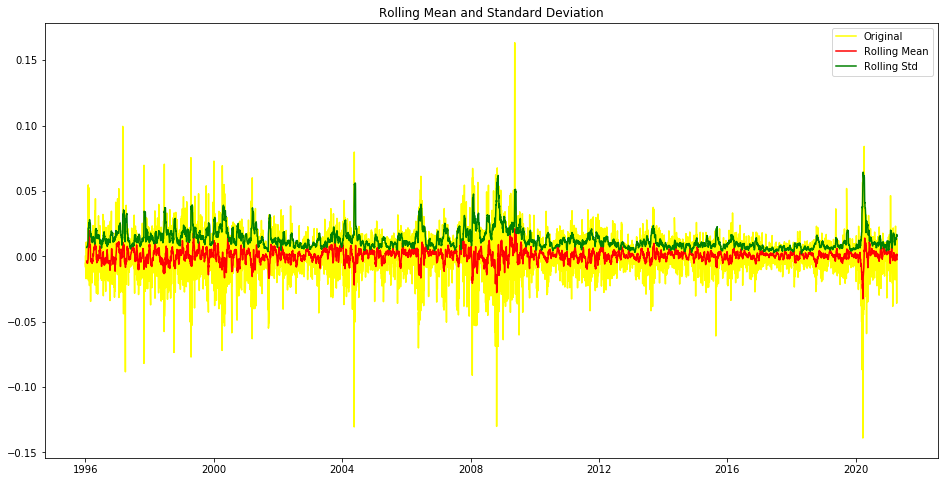

Results of dickey fuller test
Test Statistics               -1.800426e+01
p-value                        2.727842e-30
No. of lags used               1.900000e+01
Number of observations used    6.275000e+03
critical value (1%)           -3.431393e+00
critical value (5%)           -2.862001e+00
critical value (10%)          -2.567015e+00
dtype: float64


In [39]:
def test_stationarity_ondiff(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.figure(figsize=(16,8))
    plt.plot(new_date, timeseries, color='yellow',label='Original')
    plt.plot(new_date, rolmean, color='red', label='Rolling Mean')
    plt.plot(new_date, rolstd, color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity_ondiff(nifty['diff_close'])

Now, as we can see, the p-value is lesser than 0.05 so we reject the Null hypothesis. Also, the test statistics is lesser than the critical values, so the data is stationary.

### ARIMA Model

<b>Figure out the Order of ARIMA Model</b>

In [40]:
stepwise_fit = auto_arima(nifty['diff_close'], trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-34959.357, Time=3.78 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-34947.830, Time=0.64 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-34961.338, Time=0.31 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-34962.235, Time=1.60 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-34944.431, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-34965.294, Time=0.68 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-34962.694, Time=1.49 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-34962.442, Time=1.63 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-34964.536, Time=0.90 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-34964.393, Time=0.64 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-34962.216, Time=0.52 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 12.418 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 6295
Model:               SARIMAX(1, 0, 1)   Log Likelihood               17486.647
Date:                Fri, 23 Apr 2021   AIC                         -34965.294
Time:                        18:25:44   BIC                         -34938.304
Sample:                             0   HQIC                        -34955.944
                               - 6295                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.000      2.211      0.027    7.18e-05       0.001
ar.L1         -0.4443      0.102     -4.370      0.000      -0.644      -0.245
ma.L1          0.4955      0.100      4.954      0.000       0.299       0.691
sigma2         0.0002   1.76e-06    128.913      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             19761.66
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

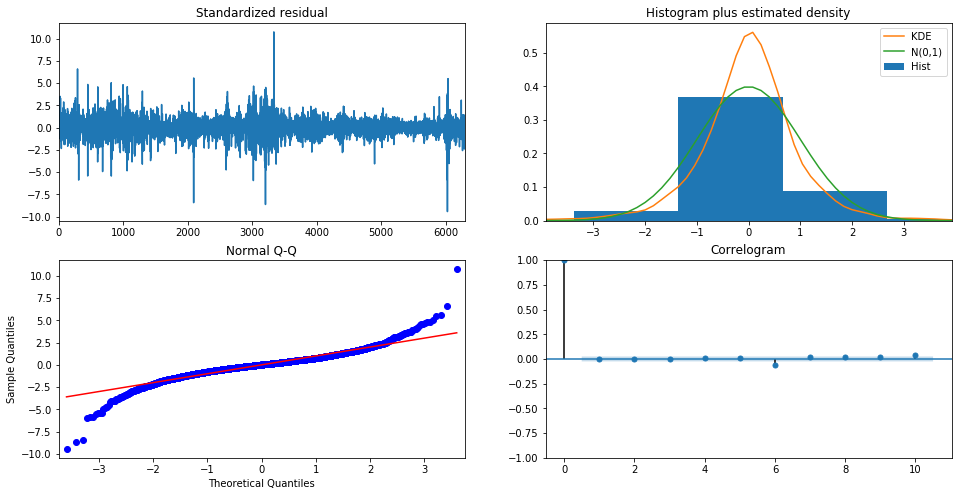

In [41]:
stepwise_fit.plot_diagnostics(figsize=(16,8))
plt.show()

<b>Split Data in training and testing dataset</b>

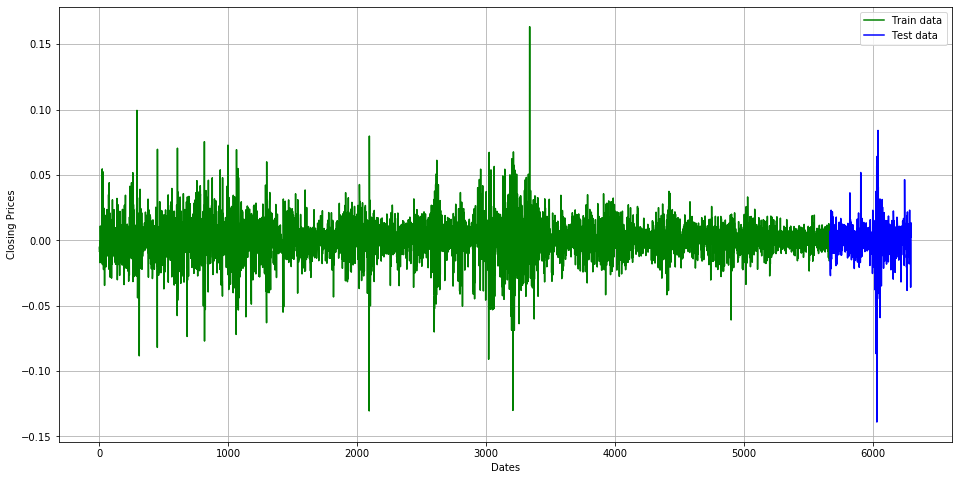

In [42]:
train_data, test_data = nifty[1:int(len(nifty)*0.9)], nifty[int(len(nifty)*0.9):]
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data['diff_close'], 'green', label='Train data')
plt.plot(test_data['diff_close'], 'blue', label='Test data')
plt.legend()

<b>Train the Model</b>

In [43]:
model = ARIMA(train_data['diff_close'], order = (1,0,1))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             diff_close   No. Observations:                 5664
Model:                     ARMA(1, 1)   Log Likelihood               15729.230
Method:                       css-mle   S.D. of innovations              0.015
Date:                Fri, 23 Apr 2021   AIC                         -31450.460
Time:                        18:25:46   BIC                         -31423.893
Sample:                             0   HQIC                        -31441.207
                                                                              
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0004      0.000      2.097      0.036    2.87e-05       0.001
ar.L1.diff_close    -0.3918      0.154     -2.543      0.011      -0.694      -0.090
ma.L1.diff_close     0.4597      0.149      3.090      0.002       0.168       0.751
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.5522           +0.0000j            2.5522            0.5000
MA.1           -2.1755           +0.0000j            2.1755            0.5000
-----------------------------------------------------------------------------
"""

<b>Make prediction for Test Data</b>

In [44]:
start = len(train_data)
end = len(train_data) + len(test_data) - 1
predict = model.predict(start = start, end = end)
nifty['Predict'] = predict

<b>Turn data back to original form</b>

In [45]:
nifty['sum_pred'] = nifty['Predict'].cumsum()

In [46]:
nifty['log_pred'] = pd.Series(nifty['log_close'].iloc[start], index=nifty['log_close'].index)
nifty['log_pred'] = nifty['log_pred'].add(nifty['sum_pred'],fill_value=0)
nifty['log_pred'] = nifty['log_pred'].iloc[start:]

In [47]:
nifty['pred_value'] = np.exp(nifty['log_pred'])

### Visualization of Final Result

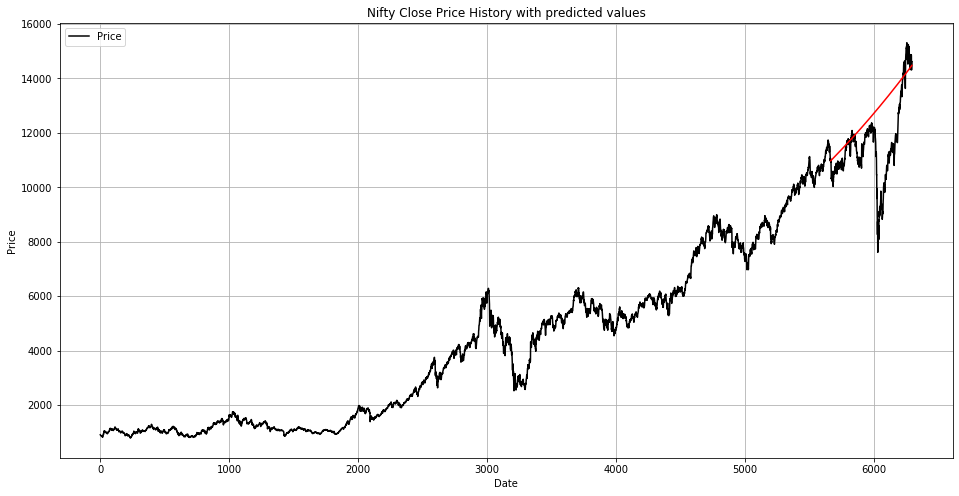

In [56]:
plt.figure(figsize=(16,8))
plt.title('Nifty Close Price History with predicted values')
plt.plot(nifty['Close'],label='Price', color='black')
plt.plot(nifty['pred_value'], color = 'red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.legend(loc=2)

### Accuracy Tests

<b>Mean Error</b>

In [49]:
me = np.mean(nifty['Predict'].iloc[start+1:] - test_data['diff_close'])
print(me)

-1.493095647615707e-05


<b>Mean Absolute Error</b>

In [50]:
mae = np.mean(np.abs(nifty['Predict'].iloc[start+1:] - test_data['diff_close']))
print(mae)

0.009349005601300945


<b>Mean Absolute Percentage Error</b>

In [51]:
mape = np.mean(np.abs(nifty['Predict'].iloc[start+1:] - test_data['diff_close']) / np.abs(test_data['diff_close']))
print(mape)

1.2482215490610553


<b>Mean Percentage Error</b>

In [52]:
mpe = np.mean((nifty['Predict'].iloc[start+1:] - test_data['diff_close'])/test_data['diff_close'])
print(mpe)

-1.2013890333706556


<b>Root Mean Square Error</b>

In [53]:
rsme = math.sqrt(mean_squared_error(nifty['Predict'].iloc[start+1:],test_data['diff_close']))
print(rsme)

0.014832512310391286


<b>Autocorrelation of errors at lag 1</b>

In [54]:
acf1 = acf(nifty['Predict'].iloc[start+1:] - test_data['diff_close'])[1]
print(acf1)

-0.0824486483395848


<b>Correlation Coefficient</b>

In [55]:
corr = np.corrcoef(nifty['Predict'].iloc[start+1:], test_data['diff_close'])[0,1]
print(corr)

0.021712168762056363
